# EDA
Taking a look at the data, mostly to determine how I will crop/downscale to input data into the model

In [39]:
# Use old efficientnet instead
# TODO : Add this install to the dockerfile
# pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-eulbrewt
  Running command git clone --filter=blob:none -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-eulbrewt
  Resolved https://github.com/qubvel/efficientnet to commit f7f3e736c113b872caf53dae9fbbda996a8eb87d
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 50 kB 6.6 MB/s             
     |████████████████████████████████| 12.4 MB 26.6 MB/s            
     |████████████████████████████████| 4.4 MB 16.7 MB/s            
     |████████████████████████████████| 3.3 MB 89.7 MB/s            
     |████████████████████████████████| 148 kB 76.8 MB/s            
     |████████████████████████████████| 1.6 MB 96.5 MB/s            
     |████████████████████████████████| 3.1 MB 76.4 MB/s            
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18447 sha256=699fd71009ffb96d81a79ecea3db44e46dc64545025cb8348cc2becbccbba557
  Stored in dire

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
from tqdm import tqdm
tqdm.pandas()

In [2]:
import cv2

In [3]:
files = glob("../data/clips/*/*.mp4")

In [4]:
clip_df = pd.DataFrame()
clip_df["path"] = files
clip_df["label"] = clip_df["path"].apply(lambda x : x.split("/")[-2])
clip_df.head()

,path,label
0,../data/clips/normal/41.mp4,normal
1,../data/clips/normal/43.mp4,normal
2,../data/clips/normal/12.mp4,normal
3,../data/clips/normal/38.mp4,normal
4,../data/clips/normal/14.mp4,normal


In [5]:
clip_df["label"].value_counts()

normal    43
hax       43
Name: label, dtype: int64

In [6]:
def get_frames(path, frames_denominator=2):
    """
    Get frames for the video at the given path
    frames_denominator specifies if frames should be dropped, pass 1 for no dropping, 2 to drop every other, 3 to drop 2/3, etc.
    """
    vidcap = cv2.VideoCapture(path)
    success,image = vidcap.read()
    frames = []
    count = 0
    while success:
        if (count % frames_denominator) == 0:
            frames.append(image)   
        success,image = vidcap.read()
        count += 1
    return frames

In [7]:
# Dropping every other frame, because having all frames just barely passes my 62.7GB of memory
clip_df["frame_list"] = clip_df["path"].progress_apply(get_frames)

100%|██████████| 86/86 [00:29<00:00,  2.95it/s]


In [8]:
clip_df["frame_count"] = clip_df["frame_list"].apply(len)

<AxesSubplot:>

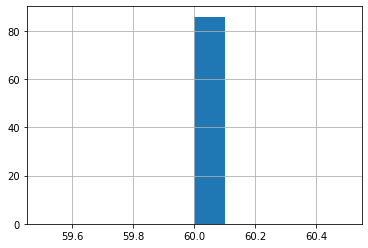

In [9]:
clip_df["frame_count"].hist()

In [10]:
clip_df["frame_count"].value_counts()

60    86
Name: frame_count, dtype: int64

In [11]:
clip_df["frame_list"][0][0].shape

(1080, 1920, 3)

# Data Issue
We can quickly see an issue with the data here- there is a big piece of text at the bottom of the page that states whether hax are on or not...

We will crop this out of the image in order to prevent the model from cheating by looking at that.

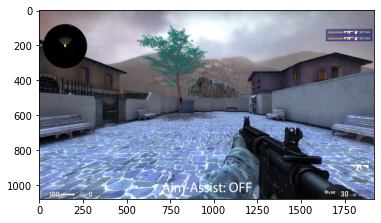

In [12]:
sample_image = clip_df["frame_list"][0][0]
plt.imshow(sample_image)

In [13]:
sample_image.shape

(1080, 1920, 3)

In [14]:
crop_shape = (448, 448)

In [15]:
def center_crop(image, center_shape=(448, 448)):
    side_crops = (image.shape[0] - center_shape[0]) // 2
    top_n_bottom_crops = (image.shape[1] - center_shape[1]) // 2
    cropped_image = image[side_crops:-side_crops,top_n_bottom_crops:-top_n_bottom_crops]
    return cropped_image

In [16]:
from skimage.transform import resize
def process_frame(frame, precrop_shape=(448, 448), input_shape=(224, 224)):
    """
    Crop a frame down into the precrop shape, then downscape to the given input shape
    """
    cropped = center_crop(frame, center_shape=precrop_shape) /255
    resized_image = resize(
        cropped,
        input_shape,
        order=3, # Bicubic interpolation
        preserve_range=True,
    )
    return resized_image

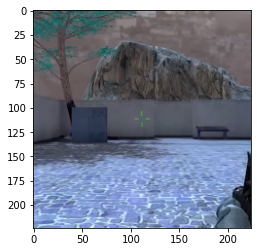

In [17]:
processed = process_frame(sample_image)
plt.imshow(processed)

# EfficientNet Selection
I am going to start off using EfficientNetB0 since we have practically no data

In [18]:
import tensorflow_hub as hub
import numpy as np

In [19]:
CNN_TRAINABLE = False
# Batch_size, time_component, length, width, depth
input_shape = (60, 224, 224, 3)

In [20]:
import efficientnet.tfkeras as efn 
efn_b0 = efn.EfficientNetB0(weights='imagenet')

In [21]:
efn_b0.output_shape

(None, 1000)

In [22]:
inputs = tf.keras.Input(shape=input_shape)
embedding_sequence = tf.keras.layers.TimeDistributed(efn_b0)(inputs)
gru_layer = tf.keras.layers.GRU(10)(embedding_sequence)
output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(gru_layer)

In [23]:
model = tf.keras.Model(inputs, output_layer)

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 60, 224, 224, 3)] 0         
_________________________________________________________________
time_distributed (TimeDistri (None, 60, 1000)          5330564   
_________________________________________________________________
gru (GRU)                    (None, 10)                30360     
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 5,360,935
Trainable params: 5,318,919
Non-trainable params: 42,016
_________________________________________________________________


In [25]:
def get_items_loop(lst, low, high):
    nums = range(low, high)
    nums = [num % len(lst) for num in nums]
    return [lst[idx] for idx in nums]

In [26]:
import random
# TODO fix batch_size not actually being batch_size
def data_generator(pos_paths, neg_paths, batch_size=8):
    assert batch_size / 2 != 0, "Batch size must be a multiple of 2 for balanced data generation"
    total_size = len(pos_paths + neg_paths)
    batch_size = batch_size//2
    while True:
        random.shuffle(pos_paths)
        random.shuffle(neg_paths)
        count = 0
        while count < total_size:
            combined_paths = get_items_loop(pos_paths, count, count+batch_size)
            combined_paths += get_items_loop(neg_paths, count, count+batch_size)
            frame_list = [[process_frame(frame) for frame in get_frames(path)] for path in combined_paths]
            count += batch_size*2
            labels = np.zeros(batch_size*2)
            labels[0:batch_size] = 1
            yield np.stack(frame_list), np.array(labels)

In [27]:
hax_paths = clip_df[clip_df["label"] == "hax"]["path"].tolist()
normal_paths = clip_df[clip_df["label"] == "normal"]["path"].tolist()
len(hax_paths)

43

In [28]:
print(len(normal_paths))

43


In [29]:
dg = data_generator(hax_paths, normal_paths, batch_size=2)

In [30]:
inp, out = next(dg)

In [33]:
out.shape

(8,)

In [35]:
model.compile(loss="binary_crossentropy", optimizer="adam")

In [36]:
model.fit_generator(dg, epochs=1, steps_per_epoch=86//batch_size)

ResourceExhaustedError:  OOM when allocating tensor with shape[480,96,112,112] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/time_distributed/block2a_expand_bn/FusedBatchNormV3 (defined at <ipython-input-36-92bd7409b2b5>:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_23125]

Function call stack:
train_function


# TF-Hub Hall of Shame

In [58]:
# TFHub is a buggy POS
# inputs = tf.keras.Input(shape=input_shape)
# conv_layer = hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2", trainable=CNN_TRAINABLE, output_shape=(1280))
# conv_layer(input_spoof)
# outputs = tf.keras.layers.TimeDistributed(conv_layer)(inputs)
# #output_layer = conv_layer(inputs)

In [44]:
# Need this to work around a bug in tfhub
# input_spoof = np.zeros([8, 224, 224, 3])